In [349]:
"""
Modules - include all modules here
"""
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import os
import cv2
from pprint import pprint
import tensorflow as tf
import keras
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Reshape, Lambda, LSTM, Dropout, Conv2D, MaxPooling2D, Embedding
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.recurrent import GRU
from keras.layers.merge import add, concatenate
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [350]:
"""
List of classes
"""

# DataElement Class
class DataElement:
    """
    This object contains variables for a single data
    @author: Kevin Jang (kj460)
    """
    label = None        # label (tag number) of this plate
    height = None       # height of this plate
    width = None        # width of this plate
    label_length = None # number of characters in this plate's label
    img = None          # parsed image
    tags = []           # data tags
    
    def __init__( self, label, height, width, label_length, img, tags ):
        """
        Constructor for this class
        @author: Kevin Jang (kj460)
        """
        self.label = label
        self.height = height
        self.width = width
        self.label_length = label_length
        self.img = img
        self.tags = tags
    
    def __str__( self ):
        """
        Returns the value of each variable for this class
        @author: Kevin Jang (kj460)
        """
        return "\t** Values:\n\t\t* label : {}\n\t\t* height : {}\n\t\t* width : {}\n\t\t* label_length = {}\n\t\t* img = {}\n\t\t* tags = {}\n".format( self.label, self.height, self.width, self.label_length, self.img, self.tags )
    
    def __repr__(self):
        """
        @author: Kevin Jang (kj460)
        """
        return self.__str__()

# DataSet Class
class DataSet:
    """
    This object contains the list of DataElement for a single dataset
    @author: Kevin Jang (kj460)
    """
    data_path = None  # path of the directory that contains data files
    data = {}         # list of DataElement
    num_redundant = 0 # number of redundant data
    num_missing = 0   # number of missing data
    num_noisy = 0     # number of noisy data

    def __init__( self, data_path ):
        """
        Constructor for this class
        @author: Kevin Jang (kj460)
        """
        self.data_path = data_path
    
    def __str__( self ):
        """
        Returns the state of each DataElement in the data list
        @author: Kevin Jang (kj460)
        """
        string = ""
        for label, data_elem in self.data.items():
            string += str( data_elem )
        return string
    
    def valid_json( self, json_data ):
        """
        Returns True if a given json_data is valid else return False
        @author: Kevin Jang (kj460)
        """
        if 'description' not in json_data or 'size' not in json_data or 'height' not in json_data[ 'size'] or 'width' not in json_data[ 'size' ] or 'tags' not in json_data or len( json_data[ 'tags' ] ) == 0:
            self.num_missing += 1
            return False
        elif len( json_data[ 'description' ] ) != 8 or int( json_data[ 'size' ][ 'width' ] ) != 152 or int( json_data[ 'size' ][ 'height' ] ) != 34:
            self.num_noisy += 1
            return False
        elif json_data[ 'description' ] in self.data.keys():
            self.num_redundant += 1
            return False
        else:
            return True
    
    def build_dataset( self, num_files ):
        """
        Reads data files and create DataElement for each data file and include it in the data list
        @author: Kevin Jang (kj460)
        @params:
            num_files - number of data files to be read; set this to 'None' to read all the files
        """
        ann_path = self.data_path + '/ann'
        img_path = self.data_path + '/img'
        count = 0
        for file in os.listdir( ann_path ):
            if num_files != None and count >= num_files:
                # stop reading
                break
            # file validation
            if '.json' not in file:
                continue
            # process JSON file
            json_file = open( ann_path + '/' + file )
            json_data = json.load( json_file )
            # data validation
            if not self.valid_json( json_data ):
                continue
            # create a new DataElement
            data_elem = DataElement( json_data[ 'description' ],
                                   json_data[ 'size' ][ 'height' ],
                                   json_data[ 'size' ][ 'width' ],
                                   len( json_data[ 'description' ] ),
                                   None,
                                   json_data[ 'tags' ] )
            # process PNG file
            img_file = cv2.imread( img_path + '/' + ( file.split( '.json' )[ 0 ] ) + '.png' )
            img_file = cv2.cvtColor( img_file, cv2.COLOR_BGR2GRAY )
            img_file = cv2.resize( img_file, ( data_elem.width, data_elem.height ) )
            img_file = img_file.astype( np.float32 ) / 255
            # add a new DataElement to the list
            data_elem.img = img_file
            self.data[ data_elem.label ] = data_elem
            count += 1
            
# TrainTestDataSet Class
class TrainTestDataSet:
    """
    This object contains DataSet for training and testing
    @author: Kevin Jang (kj460)
    """
    train_data_path = None # path of the directory that contains training data files
    test_data_path = None  # path of the directory that contains testing data files
    train_dataset = None   # training DataSet object
    test_dataset = None    # testing DataSet object
    
    def __init__( self, train_data_path, test_data_path ):
        """
        Constructor for this class
        @author: Kevin Jang (kj460)
        """
        self.train_data_path = train_data_path
        self.test_data_path = test_data_path
        
    def __str__( self ):
        """
        Returns the string that contains information about training and testing dataset
        @author: Kevin Jang (kj460)
        """
        return '*** Training Set ***\n' + str( self.train_dataset ) + '\n*** Testing Set ***\n' + str( self.test_dataset )
    
    def build_train_test_dataset( self ):
        """
        Builds training and testing DataSet
        @author: Kevin Jang (kj460)
        """
        self.train_dataset = DataSet( self.train_data_path )
        self.train_dataset.build_dataset( None )
        self.test_dataset = DataSet( self.test_data_path )
        self.test_dataset.build_dataset( None )


In [351]:
# DataValidator Class
class DataValidator:
    '''
    Validator class to check the data cleanliness
    @author: Kevin Jang (kj460)
    '''
    train_test_dataset = None
    
    def __init__( self, train_test_dataset ):
        """
        Constructor for this class
        @author: Kevin Jang (kj460)
        """
        self.train_test_dataset = train_test_dataset
        
    def __str__( self ):
        """
        Returns the string that contains information about validation on both training and testing dataset
        @author: Kevin Jang (kj460)
        """
        str = '*** DataSet Validation ***\n'
        str += '\t** Number of Redundant Data\n'
        str += '\t\t* Training DataSet : {}\n'.format( self.train_test_dataset.train_dataset.num_redundant )
        str += '\t\t* Testing DataSet : {}\n'.format( self.train_test_dataset.test_dataset.num_redundant )
        str += '\t** Number of Missing Data\n'
        str += '\t\t* Training DataSet : {}\n'.format( self.train_test_dataset.train_dataset.num_missing )
        str += '\t\t* Testing DataSet : {}\n'.format( self.train_test_dataset.test_dataset.num_missing )
        str += '\t** Number of Noisy Data\n'
        str += '\t\t* Training DataSet : {}\n'.format( self.train_test_dataset.train_dataset.num_noisy )
        str += '\t\t* Testing DataSet : {}\n'.format( self.train_test_dataset.test_dataset.num_noisy )
        return str
        

In [352]:
# directiory that contains the data files
train_data_path = 'data/ANPR_OCR__train'
test_data_path = 'data/ANPR_OCR__test'

# create TrainTestDataSet
train_test_dataset = TrainTestDataSet( train_data_path, test_data_path )
train_test_dataset.build_train_test_dataset()

# print the dataset
# print( str( train_test_dataset ) )

In [353]:
# check the cleanliness of the dataset
data_validator = DataValidator( train_test_dataset )
print( str ( data_validator ) )

*** DataSet Validation ***
	** Number of Redundant Data
		* Training DataSet : 0
		* Testing DataSet : 0
	** Number of Missing Data
		* Training DataSet : 0
		* Testing DataSet : 0
	** Number of Noisy Data
		* Training DataSet : 0
		* Testing DataSet : 0



In [356]:
sess = tf.Session()
K.set_session(sess)

In [357]:
char_set = set()
for key, value in train_test_dataset.train_dataset.data.items():
    for c in key:
        char_set.add(c)

char_list = sorted(list(char_set))
height = 34
width = 152

def label_to_indices(label):
    return list(map(lambda x: char_list.index(x), label))

def indices_to_label(indices):
    return ''.join(list(map(lambda x: char_list[int(x)], indices)))

def decoding_to_label(y):
    result = []
    for i in range(y.shape[0]):
        prev = -1
        max_index = 0
        s = ''
        for j in range(2, len(y[0])):
            for k in range(len(y[0][0])):
                if y[i][j][k] > y[i][j][max_index]:
                    max_index = k
            if max_index is not prev and max_index < len(char_list):
                s = s + char_list[max_index]
            prev = max_index
        result.append(s)
    return result

In [358]:
class ImgLabelGenerator:
    def __init__(self, ds, batch_size, down_factor):
        self.label_len = 8
        self.data_len = len(ds.data)
        self.indices = list(range(self.data_len))
        self.cur_index = 0
        self.batch_size = batch_size
        self.down_factor = down_factor
        self.imgs = np.zeros((self.data_len, height, width))
        self.labels = []
        for i, (key, value) in enumerate(ds.data.items()):
            self.labels.append(key)
            self.imgs[i, :, :] = value.img
        
    def next_element(self):
        if self.data_len-1 > self.cur_index:
            self.cur_index = self.cur_index + 1
        else:
            random.shuffle(self.indices)
            self.cur_index = 0
        position = self.indices[self.cur_index]
        return (self.labels[position], self.imgs[position])

    def next_batch(self):
        while True:
            X = np.ones([self.batch_size, width, height, 1])
            y = np.ones([self.batch_size, self.label_len])
            input_arr = np.ones((self.batch_size, 1)) * (width // self.down_factor - 2)
            label_arr = np.zeros((self.batch_size, 1))
            for i in range(self.batch_size):
                label, img = self.next_element()
                img = np.expand_dims(img.T, -1)
                X[i] = img
                y[i] = label_to_indices(label)
                label_arr[i] = len(label)
            
            inputs = {'input': X, 'labels': y, 'input_arr': input_arr, 'label_arr': label_arr}
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [363]:
def ctc_lambda_func(args):
    y_pred, labels, input_arr, label_arr = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_arr, label_arr)

ilg_train = ImgLabelGenerator(train_test_dataset.train_dataset, 8, 4)

input_data = Input(name='input', shape=(width, height, 1), dtype='float32')
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_data)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Reshape(target_shape=(width // 4, (height // 4) * 32))(x)
x = Dense(32, activation='relu')(x)

x = LSTM(64, return_sequences=True)(x)
#x = LSTM(256, return_sequences=True)(x)
#x = Dropout(0.3)(x)
x = Dense(len(char_list)+1, activation='relu')(x)
y_pred = Activation('softmax', name='sf_result')(x)
Model(inputs=input_data, outputs=y_pred).summary()

labels = Input(name='labels', shape=[ilg_train.label_len], dtype='float32')

input_arr = Input(name='input_arr', shape=[1], dtype='int64')
label_arr = Input(name='label_arr', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_arr, label_arr])
model = Model(inputs=[input_data, labels, input_arr, label_arr], outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
#test_func = K.function([input_data], [y_pred])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 152, 34, 1)        0         
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 152, 34, 32)       320       
_________________________________________________________________
max_pooling2d_185 (MaxPoolin (None, 76, 17, 32)        0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 76, 17, 32)        9248      
_________________________________________________________________
max_pooling2d_186 (MaxPoolin (None, 38, 8, 32)         0         
_________________________________________________________________
reshape_79 (Reshape)         (None, 38, 256)           0         
_________________________________________________________________
dense_144 (Dense)            (None, 38, 32)            8224      
__________

In [364]:
model.fit_generator(generator=ilg_train.next_batch(), steps_per_epoch=ilg_train.data_len, epochs=1)

Epoch 1/1
11382/11382 [==============================] - 704s 62ms/step - loss: 11.9730


The predicted plate label: 032X
Ture value of the plate label: M832XM11


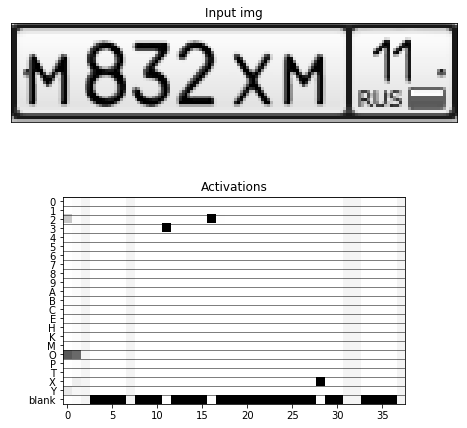

The predicted plate label: 07YO
Ture value of the plate label: H178YO11


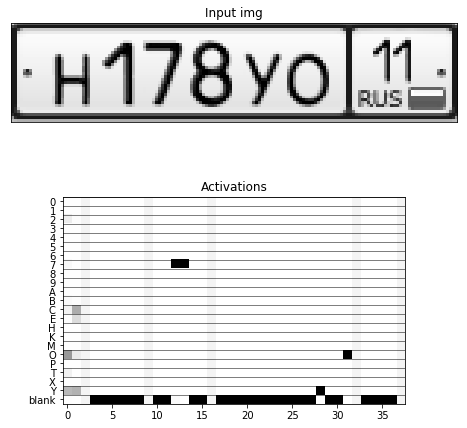

The predicted plate label: O75
Ture value of the plate label: O756PH18


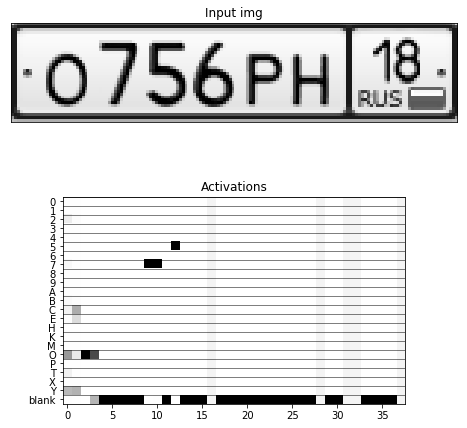

The predicted plate label: O40KB70
Ture value of the plate label: O840KB70


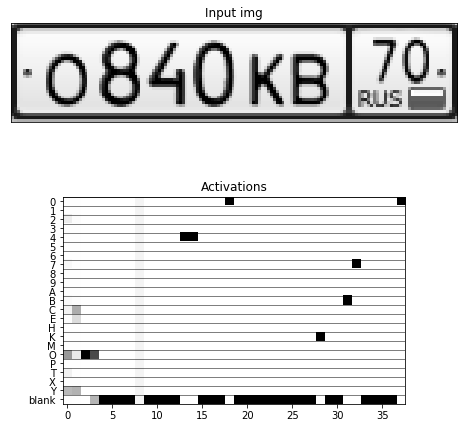

The predicted plate label: 0223TX42
Ture value of the plate label: P223TX42


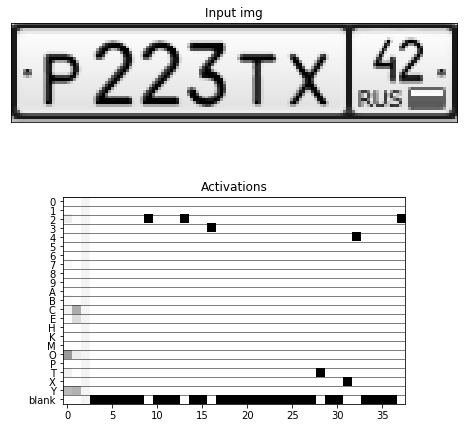

The predicted plate label: EK545E
Ture value of the plate label: K545HE91


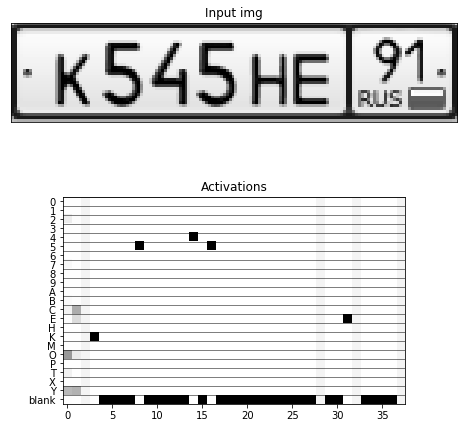

The predicted plate label: T34K
Ture value of the plate label: T384PK96


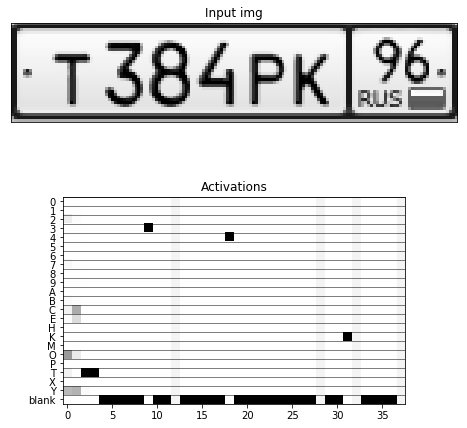

The predicted plate label: EXAT02
Ture value of the plate label: X111AT02


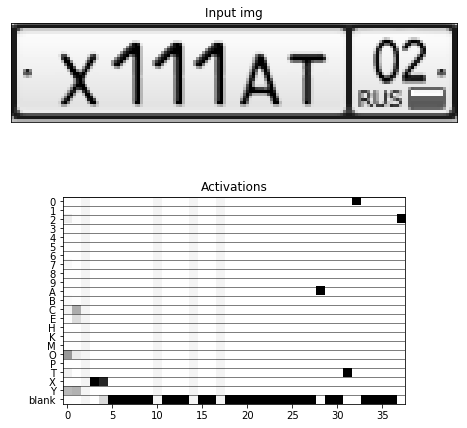

In [366]:
ilg_test = ImgLabelGenerator(train_test_dataset.train_dataset, 8, 4)

net_inp = model.get_layer(name='input').input
net_out = model.get_layer(name='sf_result').output

for inp_value, _ in ilg_test.next_batch():
    bs = inp_value['input'].shape[0]
    X = inp_value['input']
    net_out_value = sess.run(net_out, feed_dict={net_inp : X})
    pred_labels = decoding_to_label(net_out_value)
    labels = inp_value['labels']
    label_list = []
    
    for label in labels:
        label = ''.join(list(map(lambda x: char_list[int(x)], label)))
        label_list.append(label)
    
    for i in range(bs):
        fig = plt.figure(figsize=(8, 8))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('The predicted plate label:', pred_labels[i])
        print('Ture value of the plate label:', label_list[i])
        img = X[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Activations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(char_list) + 1)))
        ax2.set_yticklabels(char_list + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(char_list) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        plt.show()
    break